# Bike and Car Accident Exploratory Data Analysis #

In this EDA, I've looked at some summary statistics, plotted correlations, and displayed bar charts of qualitative data, looking for patterns in what road attributes are associated with high levels of accidents.



In [22]:
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely.wkt as wkt
import math
from shapely.geometry import Point, LineString, Polygon
from matplotlib import pyplot as plt
import seaborn as sns

In [23]:
# read in road database
rd = pd.read_csv('data/cleaned_data/road_qualities.csv').drop(columns=['Unnamed: 0'])

In [24]:
rd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74122 entries, 0 to 74121
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   car_acc_score    74122 non-null  int64  
 1   bike_acc_score   74122 non-null  int64  
 2   car_dens_score   74122 non-null  float64
 3   bike_dens_score  74122 non-null  float64
 4   Facility         74122 non-null  int64  
 5   F_Class          74122 non-null  int64  
 6   F_F_Class        74122 non-null  int64  
 7   Jurisdictn       71241 non-null  object 
 8   NHS              74122 non-null  int64  
 9   Control          74122 non-null  int64  
 10  Num_Lanes        74122 non-null  int64  
 11  Opp_Lanes        74122 non-null  int64  
 12  Surface_Tp       74122 non-null  int64  
 13  Surface_Wd       74122 non-null  int64  
 14  Shldr_Rt_W       74122 non-null  int64  
 15  Shldr_Rt_T       74122 non-null  int64  
 16  Shldr_Lt_W       74122 non-null  int64  
 17  Shldr_Lt_T  

In [25]:
# I want to look at summary statistics for bike and car accident scores
rd[['car_acc_score', 'car_dens_score']].describe()

,car_acc_score,car_dens_score
count,74122.000000,74122.000000
mean,2.006071,0.000135
std,9.257259,0.000400
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000128
max,247.000000,0.012855


In [26]:
rd[['bike_acc_score', 'bike_dens_score']].describe()

,bike_acc_score,bike_dens_score
count,74122.000000,74122.000000
mean,0.417029,0.000038
std,1.261144,0.000097
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,19.000000,0.001402


In [27]:
# I will consider places with more than 3 car accidents or more than 1 bike accident as dangerous
bike_danger = rd.query('bike_acc_score > 1')
car_danger = rd.query('car_acc_score > 3')
both_danger = rd.query('bike_acc_score > 1 and car_acc_score > 3')
len(bike_danger), len(car_danger), len(both_danger)

(5954, 7393, 1047)

In [28]:
rd['car_acc_c'] = rd.car_acc_score.mask(rd.car_acc_score > 0, 1)
rd['bike_acc_c'] = rd.bike_acc_score.mask(rd.bike_acc_score > 0, 1)

In [29]:
(rd['car_acc_c'] == rd['bike_acc_c']).sum() / len(rd)

0.5650279269312755

,car_acc_score,bike_acc_score,car_dens_score,bike_dens_score,AADT,traffic_density
car_acc_score,1.000000,0.015209,0.900317,-0.012010,0.137254,-0.000695
bike_acc_score,0.015209,1.000000,0.018672,0.924622,0.027735,0.001696
car_dens_score,0.900317,0.018672,1.000000,-0.001595,0.161367,0.000068
bike_dens_score,-0.012010,0.924622,-0.001595,1.000000,0.016488,0.003268
AADT,0.137254,0.027735,0.161367,0.016488,1.000000,0.000262
traffic_density,-0.000695,0.001696,0.000068,0.003268,0.000262,1.000000


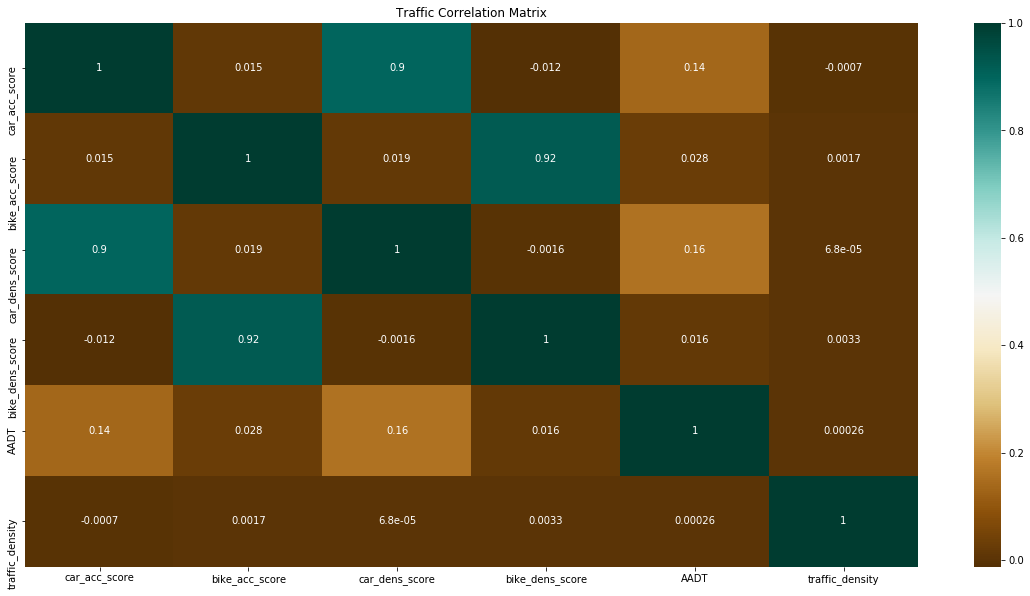

In [30]:
# I'm curious to see if there's any kind of correlation between accidents and traffic

traf = pd.read_csv('data/cleaned_data/traffic.csv').drop(columns=['Unnamed: 0'])
fig = plt.figure(figsize=(20,10))
_ = plt.title('Traffic Correlation Matrix')
c= traf.corr()
sns.heatmap(c,cmap='BrBG',annot=True)
fig.savefig('figures/traffic_corr.png')
c

This does not show very strong correlation between traffic numbers and accidents. Still going to dig into this a bit more.

,car_acc_score,bike_acc_score,car_dens_score,bike_dens_score,AADT,traffic_density
car_acc_score,1.000000,-0.106094,0.841770,-0.316186,0.142777,-0.016443
bike_acc_score,-0.106094,1.000000,-0.110216,0.881417,0.044407,-0.012159
car_dens_score,0.841770,-0.110216,1.000000,-0.135968,0.085213,0.012037
bike_dens_score,-0.316186,0.881417,-0.135968,1.000000,-0.020473,0.003050
AADT,0.142777,0.044407,0.085213,-0.020473,1.000000,-0.014280
traffic_density,-0.016443,-0.012159,0.012037,0.003050,-0.014280,1.000000


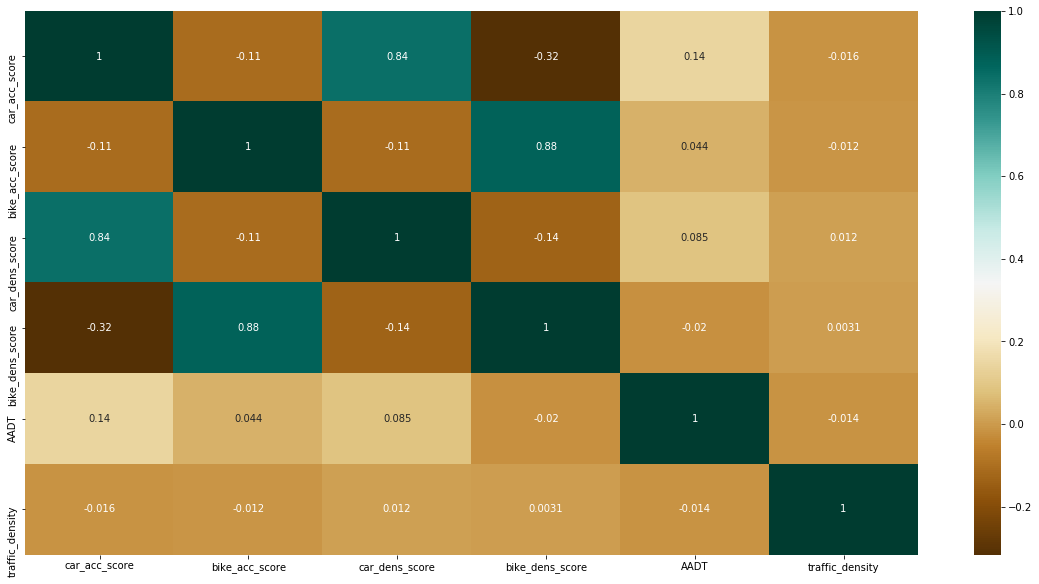

In [31]:
# trying this for more dangerous places
traf_danger = traf.query('bike_acc_score > 1 and car_acc_score > 3')
fig = plt.figure(figsize=(20,10))
c= traf_danger.corr()
sns.heatmap(c,cmap='BrBG',annot=True)
c

Still doesn't look like much correlation between traffic and accidents. 

The scatter plots below also don't reveal much correllation.

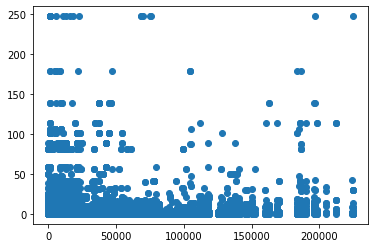

In [32]:
plt.scatter(x=traf['AADT'], y=traf['car_acc_score'])

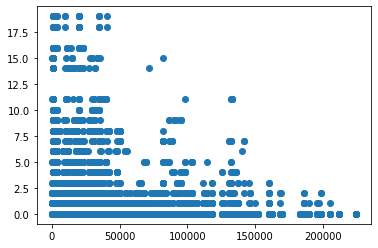

In [33]:
plt.scatter(x=traf['AADT'], y=traf['bike_acc_score'])

Now I am looking at whether any of the other quantitative road data has obvious correlations, like road width, speed limit, etc.

,car_acc_score,bike_acc_score,bike_dens_score,car_dens_score,Num_Lanes,Surface_Wd,Med_Width,Speed_Lim,ROW_Width,Opp_Lanes,Lt_Sidewlk,Rt_Sidewlk
car_acc_score,1.000000,0.016200,-0.010211,0.899867,0.012870,-0.010661,0.019075,0.075400,0.034339,0.104061,-0.057518,-0.056739
bike_acc_score,0.016200,1.000000,0.923548,0.020550,0.045995,0.042514,-0.008327,0.017102,0.084709,0.032189,0.076582,0.169184
bike_dens_score,-0.010211,0.923548,1.000000,0.000892,0.049616,0.051771,-0.013056,0.021436,0.076771,0.017658,0.104089,0.179939
car_dens_score,0.899867,0.020550,0.000892,1.000000,0.021451,0.001149,0.031023,0.088496,0.058724,0.124898,-0.068119,-0.051146
Num_Lanes,0.012870,0.045995,0.049616,0.021451,1.000000,0.771957,0.080369,0.219788,0.619971,0.391504,0.399112,0.480058
Surface_Wd,-0.010661,0.042514,0.051771,0.001149,0.771957,1.000000,0.072175,0.297778,0.613451,0.228642,0.502724,0.563335
Med_Width,0.019075,-0.008327,-0.013056,0.031023,0.080369,0.072175,1.000000,0.043334,0.283750,0.258064,-0.152639,0.059121
Speed_Lim,0.075400,0.017102,0.021436,0.088496,0.219788,0.297778,0.043334,1.000000,0.241494,0.154779,0.088349,0.172279
ROW_Width,0.034339,0.084709,0.076771,0.058724,0.619971,0.613451,0.283750,0.241494,1.000000,0.617102,0.138420,0.477907
Opp_Lanes,0.104061,0.032189,0.017658,0.124898,0.391504,0.228642,0.258064,0.154779,0.617102,1.000000,-0.256460,0.088112


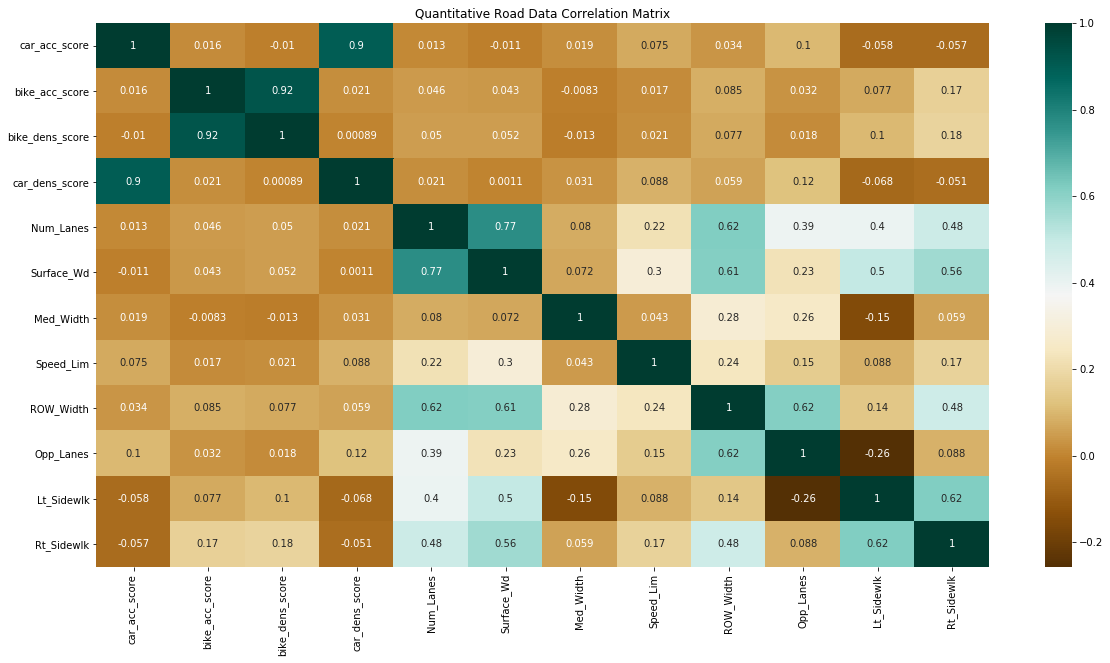

In [34]:
# run correlations on quantitative road data
q = rd[['car_acc_score', 'bike_acc_score', 'bike_dens_score', 'car_dens_score',
        'Num_Lanes', 'Surface_Wd', 'Med_Width', 'Speed_Lim', 'ROW_Width', 'Opp_Lanes',
       'Lt_Sidewlk', 'Rt_Sidewlk']]
fig = plt.figure(figsize=(20,10))
_ = plt.title('Quantitative Road Data Correlation Matrix')
c= q.corr()
sns.heatmap(c,cmap='BrBG',annot=True)
fig.savefig('figures/quant_corr.png')
c

I don't see any correlations between accidents and quantitative data about the roads.

Below I show bar charts for all of the qualitative variables to see if anything seems correlated with an increase in accidents.

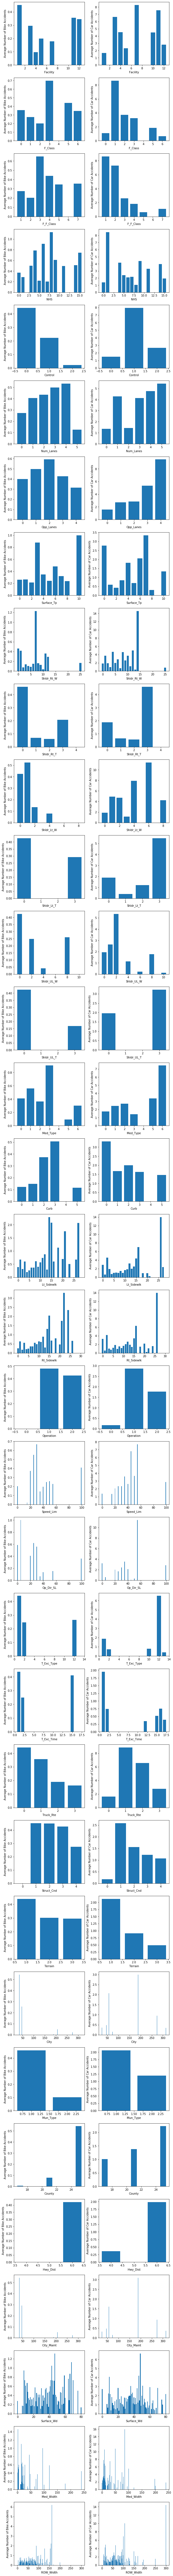

In [35]:
cols_to_plot = ['Facility', 'F_Class', 'F_F_Class', 'NHS', 
        'Control', 'Num_Lanes', 'Opp_Lanes', 'Surface_Tp', 
        'Shldr_Rt_W', 'Shldr_Rt_T', 'Shldr_Lt_W', 'Shldr_Lt_T', 'Shldr_UL_W', 
        'Shldr_UL_T', 'Med_Type', 'Curb', 'Lt_Sidewlk', 'Rt_Sidewlk', 
        'Operation', 'Speed_Lim', 'Op_Dir_SL', 'T_Exc_Type', 'T_Exc_Time', 'Truck_Rte', 
        'Struct_Cnd', 'Terrain', 'City', 'Mun_Type', 'County', 'Hwy_Dist', 
        'City_Maint', 'Surface_Wd', 'Med_Width', 'ROW_Width']

def plot_qual(data, cols_to_plot):
    # Plot qualitative data as bar charts
    fig, axs = plt.subplots(nrows=len(cols_to_plot), ncols=2, figsize=(10.0, 5.0 * len(cols_to_plot)))

    for index, col in enumerate(cols_to_plot):
        prevalence = data[data[col] > -1].groupby([col]).mean()[['bike_acc_score', 'car_acc_score']]
        axs[index][0].set_xlabel(col)
        axs[index][1].set_xlabel(col)
        axs[index][0].set_ylabel("Average Number of Bike Accidents")
        axs[index][1].set_ylabel("Average Number of Car Accidents")
        axs[index][0].bar(x=prevalence.index, height=prevalence['bike_acc_score'])
        axs[index][1].bar(x=prevalence.index, height=prevalence['car_acc_score'])

plot_qual(rd, cols_to_plot)

In [36]:
def create_bar_graph(data, colname):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10.0, 5.0))
    prevalence = data[data[colname] > -1].groupby([colname]).mean()[['bike_acc_score', 'car_acc_score']]
    axs[0].set_xlabel(colname)
    axs[1].set_xlabel(colname)
    axs[0].set_ylabel("Average Number of Bike Accidents")
    axs[1].set_ylabel("Average Number of Car Accidents")
    axs[0].bar(x=prevalence.index, height=prevalence['bike_acc_score'])
    axs[1].bar(x=prevalence.index, height=prevalence['car_acc_score'])
    fig.savefig('figures/' + colname + '_bar.png')

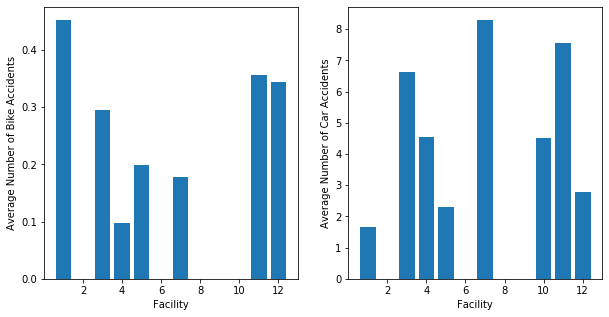

In [37]:
create_bar_graph(rd, 'Facility')

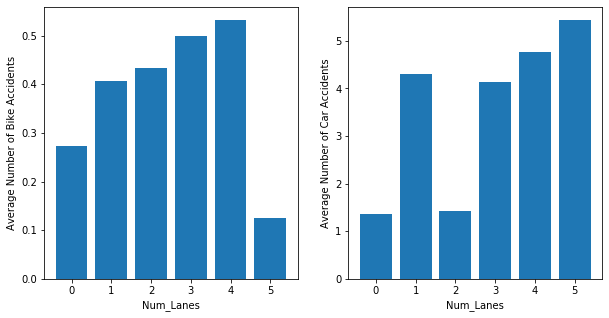

In [38]:
create_bar_graph(rd, 'Num_Lanes')

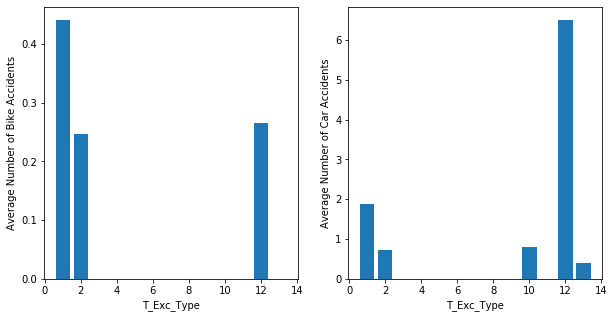

In [39]:
create_bar_graph(rd, 'T_Exc_Type')

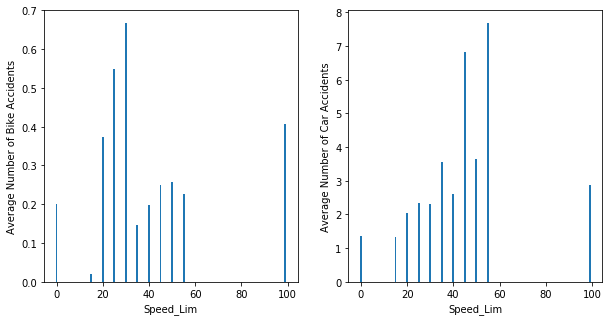

In [40]:
create_bar_graph(rd, 'Speed_Lim')

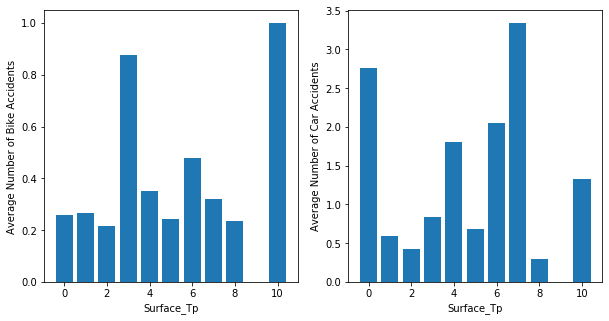

In [41]:
create_bar_graph(rd, 'Surface_Tp')

In [42]:
sl_rd = rd.query('Speed_Lim > 0 and Speed_Lim < 99')
sl_rd.Speed_Lim.describe()

count    23458.000000
mean        30.981541
std          6.822917
min         10.000000
25%         30.000000
50%         30.000000
75%         30.000000
max         55.000000
Name: Speed_Lim, dtype: float64

Speed limit is identified for a large number of entries. Based on the graph above, it appears that for cars, accidents scale with speed limit from 0 to 55. So let's see.

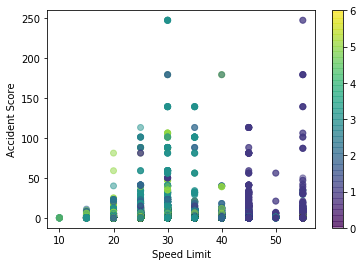

In [43]:
_ = plt.scatter(sl_rd.Speed_Lim, sl_rd.car_acc_score, alpha=0.5, c=sl_rd.F_Class)
_ = plt.xlabel('Speed Limit')
_ = plt.ylabel('Accident Score')
_ = plt.colorbar()

In [44]:
# A box plot might be a better way to look at this

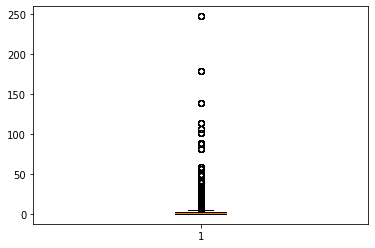

In [45]:
_ = plt.boxplot(sl_rd.car_acc_score)


This reveals the problems with my data--some giant outliers. If I do a logarithmic scale I can see the increase from zero to 30 more clearly.

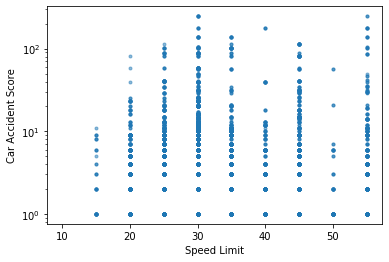

In [46]:
fig = plt.figure()
ax = plt.gca()
ax.plot(sl_rd.Speed_Lim, sl_rd.car_acc_score, alpha=0.5, linestyle='none', marker='.')
_ = plt.xlabel('Speed Limit')
_ = plt.ylabel('Car Accident Score')
_ = plt.yscale('log')

Now I want to look at the effect on bike accidents. 

In [47]:
sl_rd.groupby('Speed_Lim').bike_acc_score.count()

Speed_Lim
10       15
15       93
20     1253
25     3698
30    13445
35     2189
40      828
45     1154
50       74
55      709
Name: bike_acc_score, dtype: int64

In [48]:
#using the density score here instead of the plain score, which is just a count of accidents

box_plot_data = []
for i in range(15, 60, 5):
    box_plot_data.append(sl_rd[sl_rd['Speed_Lim'] == i].bike_dens_score)


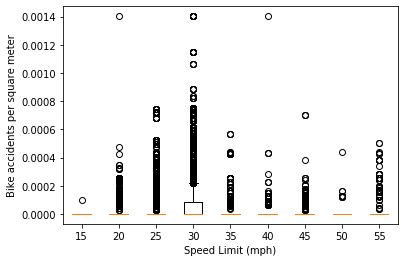

In [49]:
_ = plt.boxplot(box_plot_data)
_ = plt.ylabel('Bike accidents per square meter')
_ = plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], ['15', '20', '25', '30', '35', '40', '45', '50', '55'])
_ = plt.xlabel('Speed Limit (mph)')

## Qualitative Explorations ##

A concern for all of these is that we may not have enough data where the qualitative aspects are identified. I'm going to go through the qualitative attributes that looked interesting and see how much data is available.

### Functional Classes ###

There are several qualitative designations that have to do with the road type and usage, including Facility, F_Class, F_F_Class, NHS, Control

We see larger numbers of car accidents for Facility Types:
3 = Tunnel
7 = Simple ramp
11 = Simple ramp - tunnel

We see larger numbers of bike accidents for the above types and:

4 = Doubledeck
5 = Rotary
10 = Collector - Distributor
12 = Bicycle


In [50]:
rd.groupby('Facility').car_acc_score.count()

Facility
-1      8385
 1     60384
 3       601
 4       133
 5       316
 7      2810
 10       34
 11      463
 12      996
Name: car_acc_score, dtype: int64

The vast majority are 1 = Mainline roadway

F_class means functional class. We see large numbers of car accidents for 1 = interstate, and also 2 = Urban or Rural Principal Arterial and 3 = Urban Principal or Rural Minor Arterial. Bike accidents are higher on 1 and 3. (What are bikes doing on interstates???)

In [51]:
rd.groupby('F_Class').car_acc_score.count()

F_Class
-1     1744
 0    36345
 1     2078
 2     4340
 3    13537
 5    11485
 6     4593
Name: car_acc_score, dtype: int64

0 = Local, which is the most common, but there are a fairly large amount of data about types 1-3.

### Number of Lanes ###

Higher accidents occur with 1, 3, 4, and 5 lanes. As we see below, though, the vast majority of roads have 2 lanes.

In [52]:
rd.groupby('Num_Lanes').car_acc_score.count()

Num_Lanes
-1     1821
 0     7601
 1     7049
 2    51523
 3     2919
 4     3161
 5       48
Name: car_acc_score, dtype: int64

### Surface Type ###

More car accidents happen on surface types 0 = unknown and 7 = Portland cement concrete road

More bike accidents surface types 3 = brick road and 10 = stone dust

The numbers of non-6 (Bituminous concrete road) may not be large enough to bother with. As a bike rider, though, I can vouch that brick roads are hell to ride on!

In [53]:
rd.groupby('Surface_Tp').car_acc_score.count()

Surface_Tp
-1      2051
 0      8743
 1        49
 2       960
 3        73
 4       392
 5      7895
 6     53584
 7       337
 8        34
 9         1
 10        3
Name: car_acc_score, dtype: int64

## Truck Access ##

Higher levels of truck access does seem to have an effect on accidents, but this still may be about what data is collected.

In [54]:
rd.groupby('T_Exc_Type').car_acc_score.count()

T_Exc_Type
-1      3035
 1     66485
 2      2273
 10       20
 12     1122
 13     1187
Name: car_acc_score, dtype: int64

In [55]:
rd.groupby('T_Exc_Time').car_acc_score.count()

T_Exc_Time
-1      3035
 1     67608
 2      2121
 12       46
 15       78
 16       12
 17     1222
Name: car_acc_score, dtype: int64

## Plotting Multiple Variables ##

I just want to experiment with a heat map, Functional Class vs. Speed Limit. We see the most correlation between speed limit and car accident density for functional class 1, interstates.

In [56]:
heat_map = pd.DataFrame(rd.groupby(['F_Class', 'Speed_Lim']).car_dens_score.mean()).unstack(level=-1).fillna(value=0)
heat_map

car_dens_score                                               \
Speed_Lim            -1         0    10        15        20        25   
F_Class                                                                 
-1              0.000222  0.000000  0.0  0.000000  0.000000  0.000000   
 0              0.000083  0.000017  0.0  0.000000  0.000079  0.000101   
 1              0.000000  0.000000  0.0  0.000000  0.000000  0.000309   
 2              0.000319  0.000000  0.0  0.000261  0.000177  0.000270   
 3              0.000061  0.000252  0.0  0.000047  0.000165  0.000152   
 5              0.000328  0.000114  0.0  0.000228  0.000146  0.000121   
 6              0.000000  0.000084  0.0  0.000000  0.000000  0.000051   

                                                                       \
Speed_Lim        30        35        40        45        50        55   
F_Class                                                                 
-1         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 0         0.000054  0.000099  0.000000  0.000000  0.000000  0.000000   
 1         0.000373  0.000500  0.000200  0.000394  0.000256  0.000559   
 2         0.000201  0.000203  0.000285  0.000093  0.000000  0.000000   
 3         0.000172  0.000264  0.000117  0.000048  0.000038  0.000523   
 5         0.000135  0.000108  0.000208  0.000348  0.000000  0.000121   
 6         0.000053  0.000087  0.000000  0.000064  0.000000  0.000000   

                     
Speed_Lim        99  
F_Class              
-1         0.000000  
 0         0.000684  
 1         0.000420  
 2         0.000423  
 3         0.000382  
 5         0.000145  
 6         0.000058

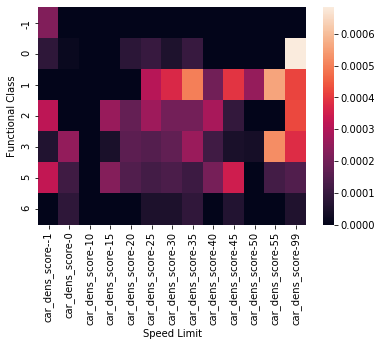

In [57]:
_ = sns.heatmap(heat_map)
_ = plt.ylabel('Functional Class')
_ = plt.xlabel('Speed Limit')

I think it would also be interesting to look at this for number of lanes.

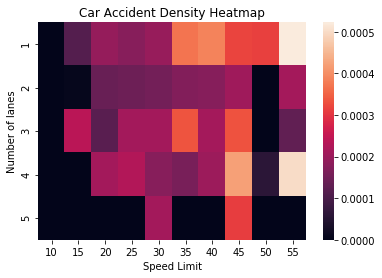

In [58]:
heat_map = pd.DataFrame(rd.query('Num_Lanes > 0 and Speed_Lim > 0 and Speed_Lim < 99').groupby(['Num_Lanes', 'Speed_Lim']).car_dens_score.mean()).unstack(level=-1).fillna(value=0)
fig = sns.heatmap(heat_map, xticklabels=[10, 15, 20, 25, 30, 35, 40, 45, 50, 55])
_ = plt.ylabel('Number of lanes')
_ = plt.xlabel('Speed Limit')
_ = plt.title('Car Accident Density Heatmap')
fig.figure.savefig('figures/lanes_speed_heatmap.png')

## Conclusions and Next Steps ##

I've found some areas that I want to perform some statistical analysis to see if there are significant correlations:

1. Speed Limit, especially dividing it into 0 to 30 and 35 to 55
2. Facility qualitative designations
3. Number of lanes--to some degree, Speed Limit scales with number of lanes
4. Truck exclusion type--it seems obvious but excluding trucks seems to decrease accidents
5. Surface Type